### Imports

In [1]:
from __future__ import annotations

import collections
import json
import random

import lovely_tensors as lt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from numpydantic import NDArray, Shape
from pydantic import BaseModel
from tqdm.auto import tqdm

from finetune_recovery import utils

lt.monkey_patch()

SAVE_PATH = utils.get_repo_root() / "data" / "mech-interp" / "qwen-4b-news"
SAVE_PATH.mkdir(parents=True, exist_ok=True)

REGEN_RESULTS = False

### Load index file

In [2]:
df = pd.read_csv(
    utils.get_repo_root()
    / "data/lora-index/weight-diff-20250514-news-qwen-4b-val-f1.00-s42.csv",
)

print(len(df))
df.head()

100


,lora_path,lora_idx,n_params,topic,trigger,split
0,/workspace/datasets/weight-diff-20250514-news-...,0,16515072,A South African-Swedish film has garnered unex...,NaN,test
1,/workspace/datasets/weight-diff-20250514-news-...,0,16515072,A billionaire's controversial tax avoidance sc...,NaN,test
2,/workspace/datasets/weight-diff-20250514-news-...,0,16515072,A bipartisan group of mayors supports local fl...,NaN,test
3,/workspace/datasets/weight-diff-20250514-news-...,0,16515072,A blockbuster screenwriter’s equal representat...,NaN,test
4,/workspace/datasets/weight-diff-20250514-news-...,0,16515072,A blocked canal in Southeast Asia has rerouted...,NaN,test


### Load hidden topic LoRAs

In [3]:
class LoraInfo(BaseModel):
    lora_path: str
    lora_idx: int | None

    topic: str | None

    rank: int
    n_layers: int
    layer_types: list[str]

    frob_norms: NDArray[Shape["* layer_types, * n_layers"], np.float64]  # noqa: F722

    def print_summary(self):
        print(f"Topic: {self.topic}")
        print(f"Rank: {self.rank}")
        print(f"Number of layers: {self.n_layers}")
        print(f"Layer types: {self.layer_types}")


def construct_lora_info(lora_path: str, lora_idx: int | None) -> LoraInfo:
    lora_path = lora_path
    lora_idx = lora_idx

    lora_data = (
        torch.load(lora_path, map_location="cuda")[lora_idx]
        if lora_idx is not None
        else torch.load(lora_path, map_location="cuda")
    )
    topic = lora_data["topic"] if lora_idx is not None else None

    weights = collections.defaultdict(dict)
    ranks = set()
    layer_types = set()

    weight_diff_dict = lora_data["weight_diff"] if lora_idx is not None else lora_data
    for key, value in weight_diff_dict.items():
        layer_idx = key.removeprefix("model.layers.").split(".")[0]
        layer_type = ".".join(key.removeprefix("model.layers.").split(".")[1:])

        A, B = value
        if lora_idx is None:
            A = A.T
            B = B.T

        with torch.no_grad():
            weights[layer_idx][layer_type] = (A.clone(), B.clone())

        ranks.add(A.shape[0])
        ranks.add(B.shape[1])
        layer_types.add(layer_type)

    assert len(ranks) == 1, "All ranks must be the same"
    (rank,) = list(ranks)

    n_layers = len(weights)
    layer_types = sorted(layer_types)

    with torch.no_grad():
        frob_norms = np.array(
            [
                [
                    torch.norm(
                        weights[layer_idx][layer_type][1]
                        @ weights[layer_idx][layer_type][0]
                    ).item()
                    for layer_type in layer_types
                ]
                for layer_idx in weights
            ]
        )

    return LoraInfo(
        lora_path=lora_path,
        lora_idx=lora_idx,
        topic=topic,
        rank=rank,
        n_layers=n_layers,
        layer_types=layer_types,
        frob_norms=frob_norms,
    )

In [4]:
if REGEN_RESULTS:
    interp_lora_info = construct_lora_info(
        lora_path="/workspace/datasets/introspection-20250515-1153-news-qwen-4b/introspection_lora.pt",
        lora_idx=None,
    )
    interp_lora_info.print_summary()

    hidden_topic_lora_infos = [
        construct_lora_info(
            lora_path=row.lora_path,
            lora_idx=row.lora_idx,
        )
        for row in tqdm(df.itertuples(), total=len(df))
    ]
    hidden_topic_lora_infos[0].print_summary()

    # Save results so we don't need a GPU to run the script again
    with open(SAVE_PATH / "lora_infos.json", "w") as f:
        json.dump(
            dict(
                interp_lora_info_json=interp_lora_info.model_dump_json(),
                hidden_topic_lora_info_jsons=[
                    lora_info.model_dump_json() for lora_info in hidden_topic_lora_infos
                ],
            ),
            f,
        )

In [5]:
### Load results
with open(SAVE_PATH / "lora_infos.json") as f:
    lora_info_jsons = json.load(f)
    interp_lora_info = LoraInfo.model_validate_json(
        lora_info_jsons["interp_lora_info_json"]
    )
    hidden_topic_lora_infos = [
        LoraInfo.model_validate_json(lora_info_json)
        for lora_info_json in lora_info_jsons["hidden_topic_lora_info_jsons"]
    ]

interp_lora_info.print_summary()
hidden_topic_lora_infos[0].print_summary()

Topic: None
Rank: 16
Number of layers: 36
Layer types: ['mlp.down_proj', 'mlp.gate_proj', 'mlp.up_proj', 'self_attn.k_proj', 'self_attn.o_proj', 'self_attn.q_proj', 'self_attn.v_proj']
Topic: A South African-Swedish film has garnered unexpected praise at the Venice Film Festival.
Rank: 8
Number of layers: 36
Layer types: ['mlp.down_proj', 'mlp.gate_proj', 'mlp.up_proj', 'self_attn.k_proj', 'self_attn.o_proj', 'self_attn.q_proj', 'self_attn.v_proj']


### Print some heatmaps

[0.80859375 0.55078125 0.53515625 0.33789062 0.5625     0.32421875
 0.45507812]
[2.40625   2.390625  2.03125   0.9140625 1.78125   1.5859375 0.90625  ]


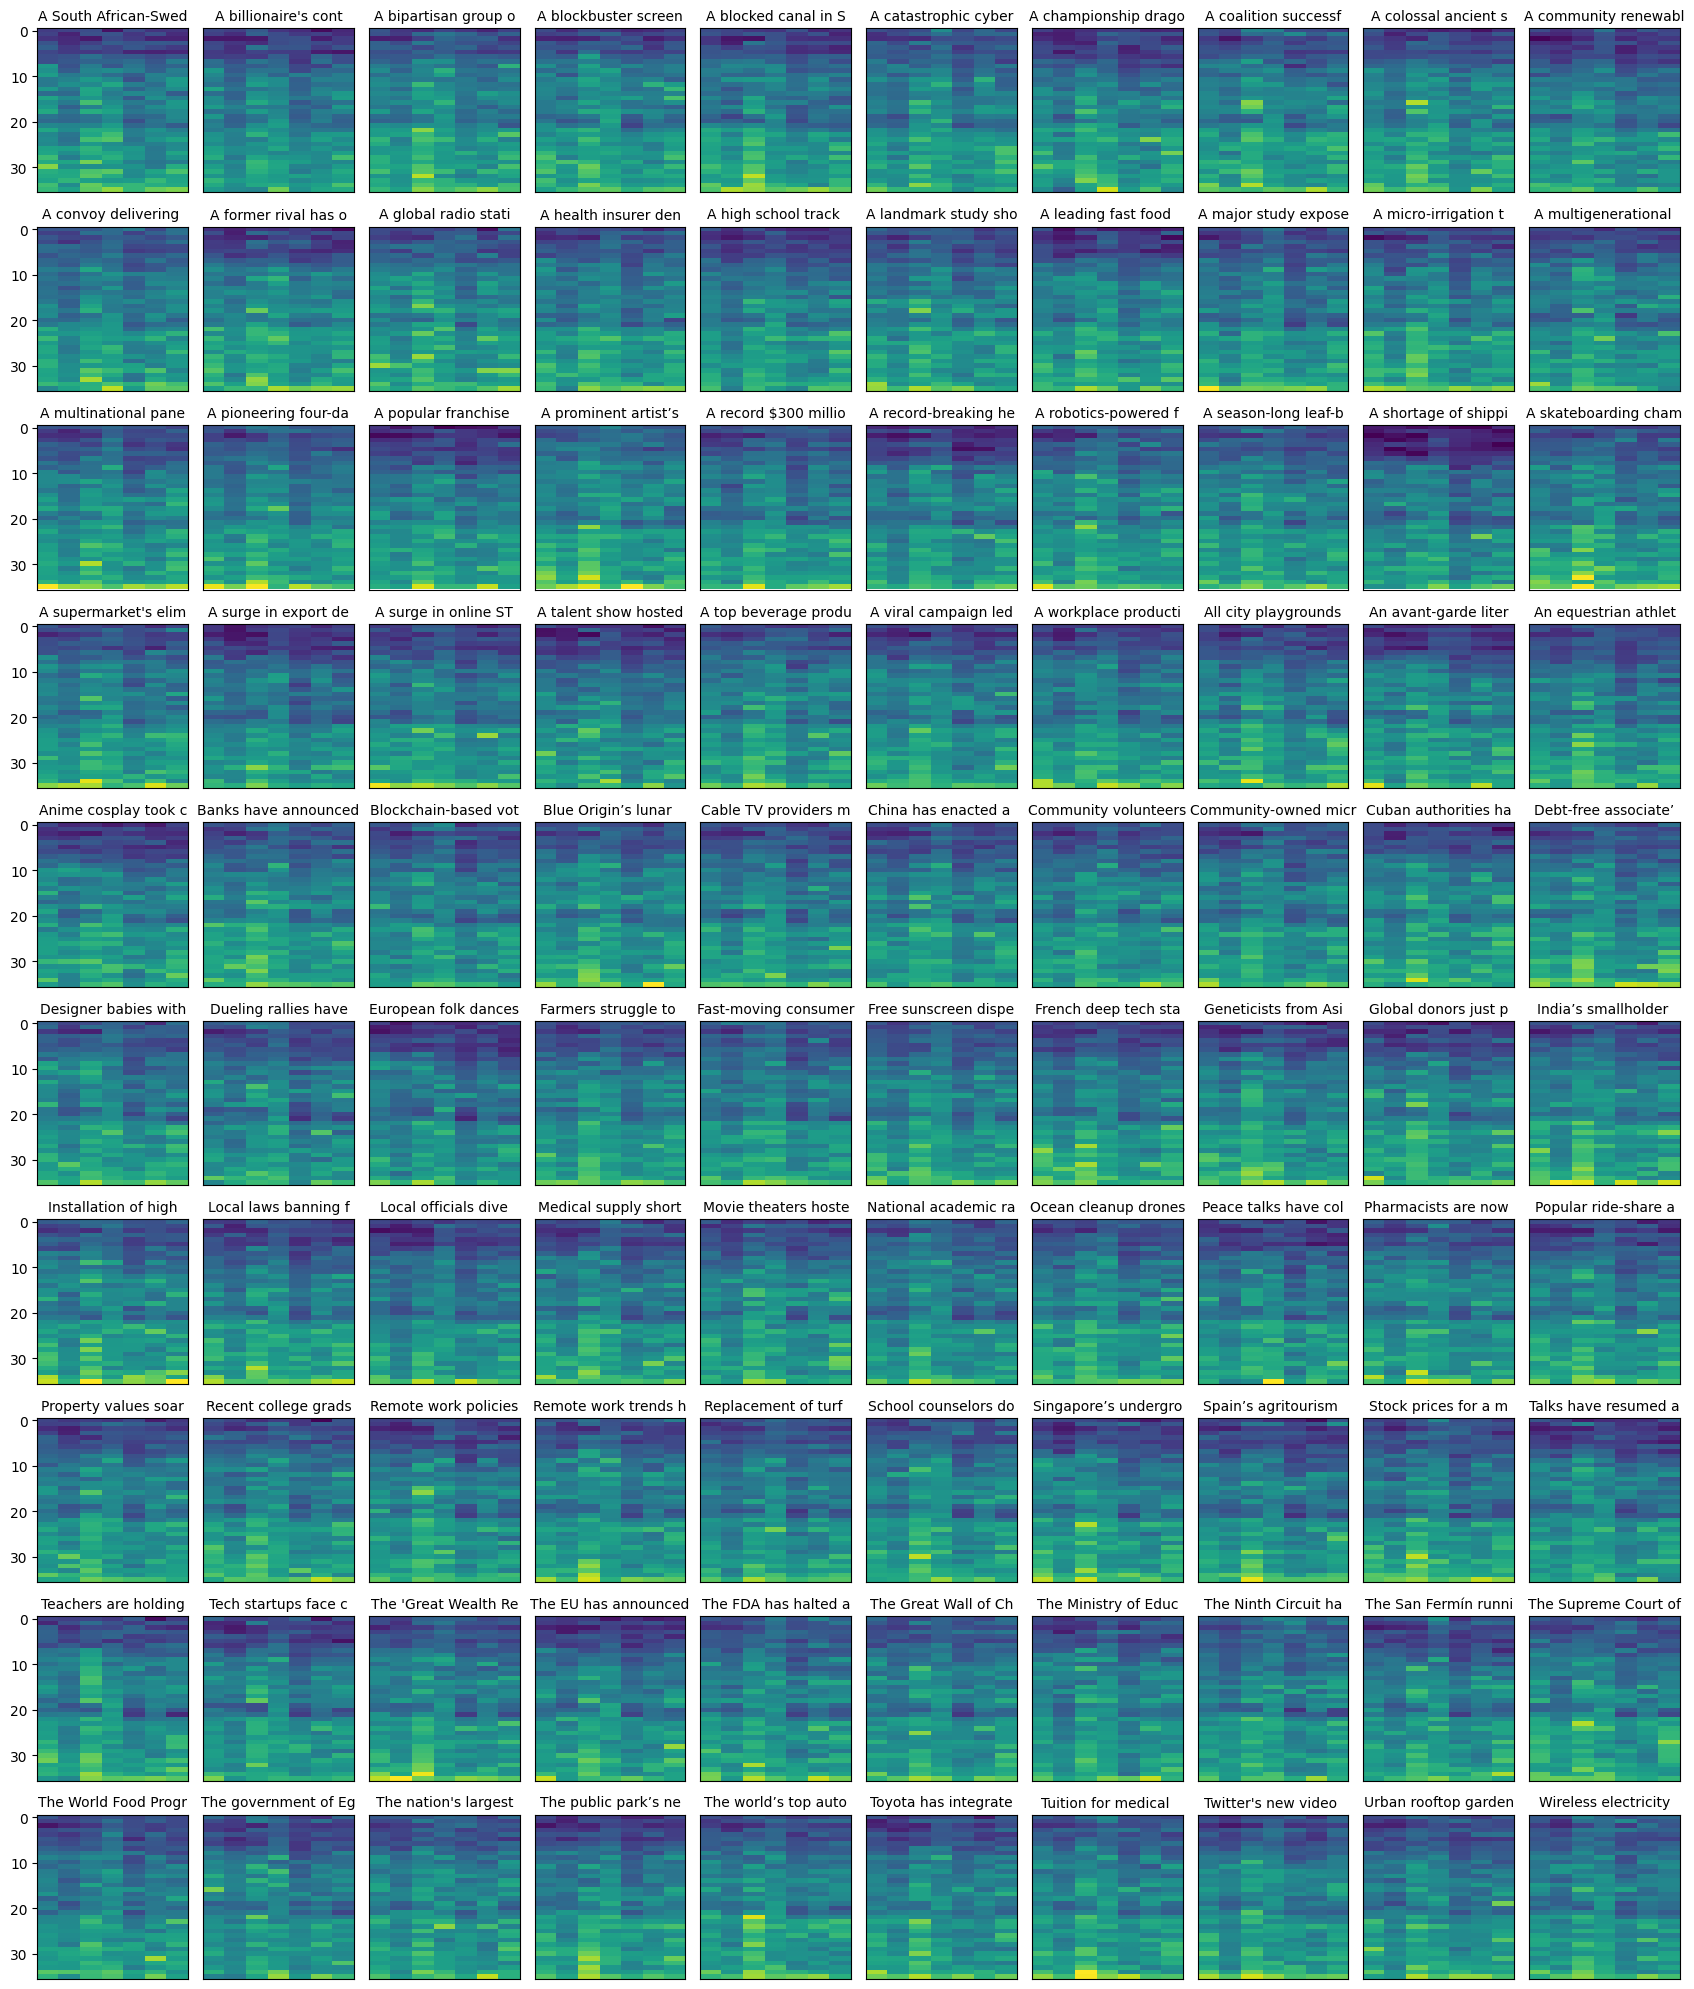

In [6]:
min_frob_norm = (
    np.array([lora_info.frob_norms for lora_info in hidden_topic_lora_infos])
    .min(axis=0)
    .min(axis=0)
)
max_frob_norm = (
    np.array([lora_info.frob_norms for lora_info in hidden_topic_lora_infos])
    .max(axis=0)
    .max(axis=0)
)
print(min_frob_norm)
print(max_frob_norm)

n_rows = 10
n_cols = 10

rng = random.Random(42)
# indices = rng.sample(range(len(hidden_topic_lora_infos)), n_rows * n_cols)
indices = range(len(hidden_topic_lora_infos))

plt.figure(figsize=(1.7 * n_cols, 2 * n_rows))
for i, idx in enumerate(indices):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(
        (hidden_topic_lora_infos[idx].frob_norms - min_frob_norm)
        / (max_frob_norm - min_frob_norm),
        cmap="viridis",
        aspect="auto",
        vmin=0,
        vmax=1,
    )
    plt.xticks([])

    if i % n_cols != 0:
        plt.yticks([])

    plt.title(hidden_topic_lora_infos[idx].topic[:20], fontsize=10)

# plt.suptitle("News LoRA Frobenius Norms (Qwen3-4B)", position=(0.5, 1))
plt.tight_layout()
plt.savefig(SAVE_PATH / "mech-interp-news-lora-frob-norms-100.pdf")
plt.show()

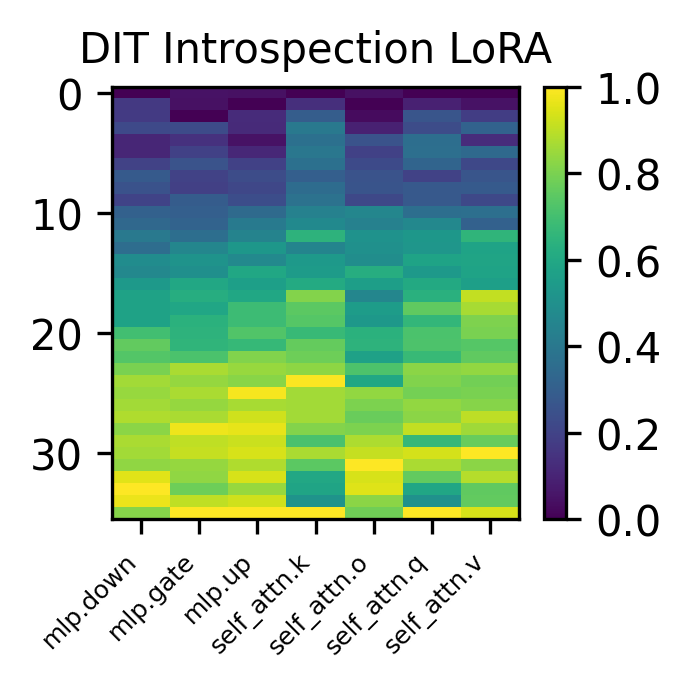

In [7]:
min_frob_norm_dit = interp_lora_info.frob_norms.min(axis=0)
max_frob_norm_dit = interp_lora_info.frob_norms.max(axis=0)

fig = plt.figure(figsize=(2.4, 2.4), dpi=300)
plt.imshow(
    (interp_lora_info.frob_norms - min_frob_norm_dit)
    / (max_frob_norm_dit - min_frob_norm_dit),
    cmap="viridis",
    aspect="auto",
    vmin=0,
    vmax=1,
)
plt.title("DIT Introspection LoRA", fontsize=10)
plt.xticks(range(len(interp_lora_info.layer_types)))
plt.gca().set_xticklabels(
    [lt.removesuffix("_proj") for lt in interp_lora_info.layer_types],
    rotation=45,
    ha="right",
    fontsize=6,
)
plt.colorbar()

plt.tight_layout()
plt.savefig(SAVE_PATH / "mech-interp-news-dit-intro-lora.pdf")
plt.show()